#### Importing Libraries
Libraries like pandas, numpy, and keras are fundamental for data manipulation, machine learning modeling, and image processing

In [1]:
import os
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


1. Dataset preparation
2. Data manipulation for CNN
3. Building the CNN Model
4. Analysis of the CNN

### 1. Dataset preparation

The dataset is loaded from a CSV file using pandas. The loaded dataset can be obtained be running notebook: data_integration.ipynb

In [5]:
# Load the dataset
final_df = pd.read_csv('../../../data/integrated_data.csv')

# Display the first few rows
print(final_df.head())

   Unnamed: 0                track_id explicit  \
0           0  1TJfx5wZrjAtvGc2LcRD50        t   
1           1  3gTN5N6qtxokiy1MSAyRHf        t   
2           2  6QXxvRGql81hrkNKl1sJNy        f   
3           3  6R5Ut5Mb88EqyLLiNaIOD0        f   
4           4  7o7Qx3kulN6A0uOaAPf5Vz        f   

                                         preview_url release_date  popularity  \
0  https://p.scdn.co/mp3-preview/5089e683a4b81f8f...         1995        12.0   
1  https://p.scdn.co/mp3-preview/7f0559e58f37f040...         1995        34.0   
2  https://p.scdn.co/mp3-preview/1883d8ef8a5628f0...   2019-09-13        21.0   
3  https://p.scdn.co/mp3-preview/6b57227204be23bd...   2022-07-28        28.0   
4  https://p.scdn.co/mp3-preview/4229181352cb0c16...   2022-07-28        26.0   

   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.10000         0.559       207107   0.958          0.636000    3   
1       0.03080         0.677       335133   0.921        

Load folder with with generated images

In [6]:
image_directory = 'Spectograms_images'

Create functions to extract sample id from preview_url and later use it to get a specific generated image

In [7]:
# Function to extract sample_id from preview_url
def extract_sample_id(url):
    if pd.notna(url):
        start = url.find("mp3-preview/") + len("mp3-preview/")
        end = url.find("?", start)
        return url[start:end] if start > len("mp3-preview/") else None
    return None

# Apply the function to the 'preview_url' column
final_df['sample_id'] = final_df['preview_url'].apply(extract_sample_id)

In [8]:
def get_image(sample_id):
    if sample_id is not None:
        image_path = os.path.join(image_directory, f"{sample_id}_spectrogram.png")
        if os.path.exists(image_path):
            # Load and immediately close the image file
            with Image.open(image_path) as img:
                return np.array(img)  # Return the image as a NumPy array
    return None

Link images to dataset so we can use popularity to classify our images later

In [9]:
# Link images to the dataset entries
final_df['image'] = final_df['sample_id'].apply(get_image)

Here we have displayed first 5 images to verify that the process completed earlier is correct

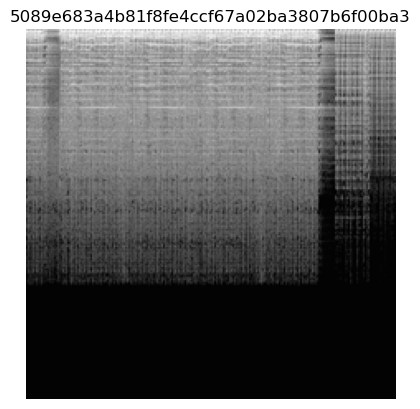

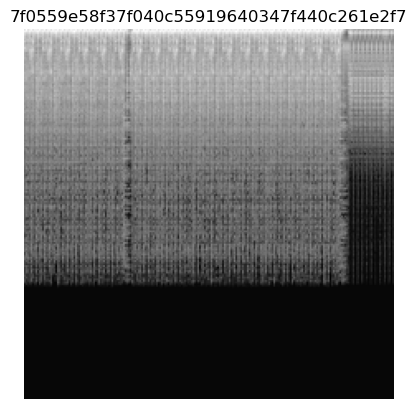

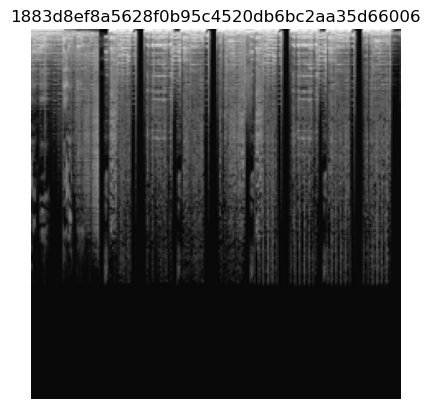

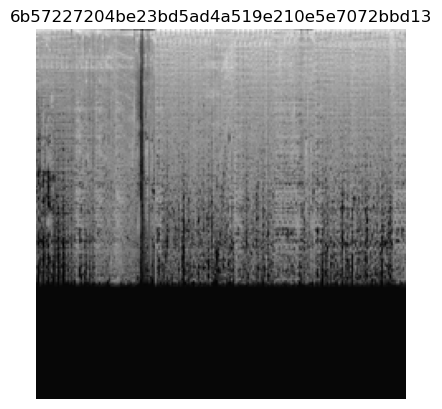

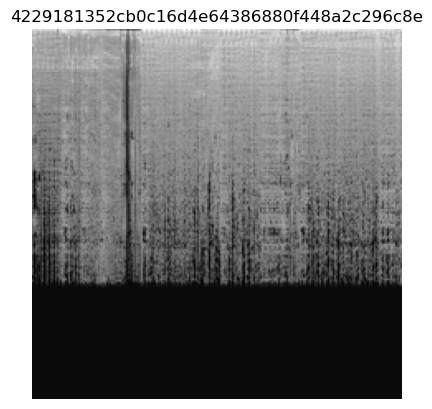

In [10]:
# Display the first few images
for i in range(5):  # Adjust the range as needed
    image = final_df['image'][i]
    if image is not None:
        plt.imshow(image)
        plt.title(final_df['sample_id'][i])
        plt.axis('off')
        plt.show()
    else:
        print(f"No image for index {i}")

Now we are working with popularity. We have decided that we will have 3 labes for popularity: Low, Medium, High

We are dividing popularity into 3 different bins

In [11]:
pd.cut(final_df['popularity'], bins=3) #Making 3 equal bins

0         (-0.083, 27.667]
1         (27.667, 55.333]
2         (-0.083, 27.667]
3         (27.667, 55.333]
4         (-0.083, 27.667]
                ...       
489519    (-0.083, 27.667]
489520    (-0.083, 27.667]
489521    (-0.083, 27.667]
489522    (-0.083, 27.667]
489523    (-0.083, 27.667]
Name: popularity, Length: 489524, dtype: category
Categories (3, interval[float64, right]): [(-0.083, 27.667] < (27.667, 55.333] < (55.333, 83.0]]

Below is represented how many values we have in each bin

In [12]:
pd.cut(final_df['popularity'], bins=3, labels = ["low", "medium", "high"]).value_counts() #value count of the bins

popularity
low       472649
medium     16398
high         477
Name: count, dtype: int64

Now we have labeled each bin

In [13]:
final_df['label'] = pd.cut(final_df.popularity, bins=3, labels=["low", "medium", "high"], right=True) #New label for popularity

As some of the songs do not have preview_url and some of the songs with preview_url do not have generated spectrogram, we need to filter our dataset.

In [14]:
# Filter the DataFrame to include only rows with images
final_df_with_images = final_df.dropna(subset=['image'])

# Verify the remaining number of entries
print(f"Number of entries with images: {len(final_df_with_images)}")

Number of entries with images: 208353


### 2. Data manipulation for CNN

Sampling is particularly useful in large datasets to reduce computational demands.

This code prepares the dataset for training a CNN by sampling, processing labels, and splitting the data into training and test sets in a balanced manner. This preparation is crucial for effective and accurate model training and evaluation.

We can change the number of values to be sampled: n
In our case, we have sampled 10000 random values from the dataset


In [23]:
# Sample only n values from the dataset
sampled_df = final_df_with_images.sample(n=10000, random_state=42)

# Prepare the image data
X = np.stack(sampled_df['image'].values)

# Prepare the labels (use the binned popularity as labels)
# Convert labels to numerical format if they're categorical
label_mapping = {'low': 0, 'medium': 1, 'high': 2}
y = sampled_df['label'].map(label_mapping).values

# One-hot encode the labels for classification
y = to_categorical(y, num_classes=3)

# Stratify based on labels while splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### 3. Building the CNN Model

This is where the Convolutional Neural Network (CNN) model is defined using Keras. The architecture is designed layer by layer, demonstrating how neural networks can be constructed in a modular way.

This model architecture is typical for image classification tasks, where convolutional layers are used to extract features from images, and dense layers are used to interpret these features and make classification predictions. The use of dropout helps in reducing overfitting, and the softmax output makes it suitable for multi-class classification problems.

In [24]:
model = Sequential()
# Convolutional layer with 32 filters, a kernel size of 3x3, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
# Add more convolutional layers
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Flatten())  # Flatten the output to feed into the dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
model.add(Dense(3, activation='softmax'))  # Final layer with softmax activation, one neuron per class

This code below configures the CNN model with the Adam optimizer, uses categorical cross-entropy as the loss function to guide the learning process, and sets accuracy as the metric for evaluating the model's performance.

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

This code below will start the training process of the model on our dataset.

During training, the model will learn to classify images into categories based on their features, and the validation split will help in monitoring its performance and generalization capability.

In [26]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 16s 81ms/step - loss: 312.1607 - accuracy: 0.9438 - val_loss: 0.7842 - val_accuracy: 0.9731
Epoch 2/10
200/200 [==============================] - 16s 80ms/step - loss: 0.9064 - accuracy: 0.9638 - val_loss: 0.5300 - val_accuracy: 0.9731
Epoch 3/10
200/200 [==============================] - 16s 80ms/step - loss: 0.4714 - accuracy: 0.9652 - val_loss: 0.3854 - val_accuracy: 0.9731
Epoch 4/10
200/200 [==============================] - 16s 80ms/step - loss: 0.3084 - accuracy: 0.9653 - val_loss: 0.3580 - val_accuracy: 0.9731
Epoch 5/10
200/200 [==============================] - 16s 81ms/step - loss: 0.2818 - accuracy: 0.9653 - val_loss: 0.3575 - val_accuracy: 0.9731
Epoch 6/10
200/200 [==============================] - 16s 80ms/step - loss: 0.2549 - accuracy: 0.9653 - val_loss: 0.3415 - val_accuracy: 0.9731
Epoch 7/10
200/200 [==============================] - 16s 81ms/step - loss: 0.2414 - accuracy: 0.9653 - val_loss: 0.3062 - val_accurac

### 4. Analysis of the CNN

##### General Observations
The model was trained over 10 epochs, each involving 200 steps per epoch.
There is a consistent trend of decreasing loss and stable accuracy across epochs.

##### Specific Observations
Epoch 1:
Training Loss: 312.1607
Training Accuracy: 94.38%
Validation Loss: 0.7842
Validation Accuracy: 97.31%

The initial high training loss quickly reduced, suggesting rapid initial learning.


Subsequent Epochs (2-10):

The training loss consistently decreased, reaching a low of 0.1850 in Epoch 9.
The training accuracy remained relatively stable around 96-97%.
Validation loss consistently decreased, stabilizing around 0.2375 in the final epochs.
Validation accuracy was consistently high, around 97.31%, but slightly decreased to 97.25% in the final epoch.

##### Analysis
Learning Trend: The model demonstrates a good learning trend with decreasing loss, which is a positive indicator.
Accuracy Plateau: Both training and validation accuracies show very little variation across epochs, which might suggest that the model reached a performance plateau early in the training.
Consistent Validation Accuracy: The high and stable validation accuracy suggests that the model generalizes well on unseen data
Overfitting: From around Epoch 8, the training loss increases slightly while the validation loss decreases, which could be a sign of overfitting, although the effect is minimal.

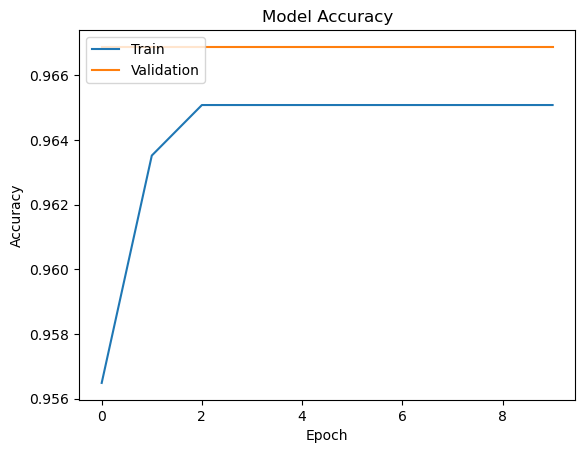

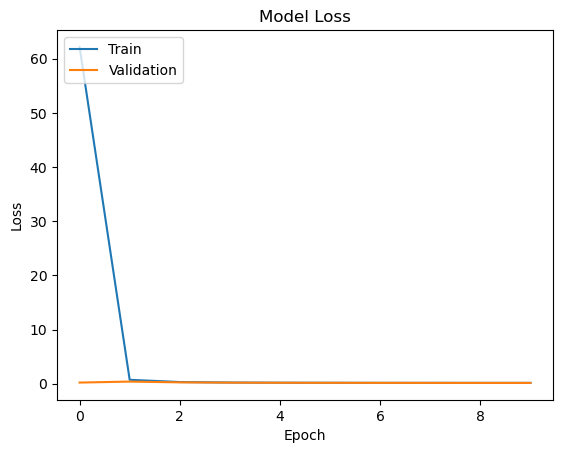

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

125/125 [==============================] - 2s 18ms/step - loss: 0.1624 - accuracy: 0.9655
Test accuracy: 0.97
